# Import Libraries

In [14]:
import numpy as np
import pandas as pd
import copy
import time
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
import timm
from timm.loss import LabelSmoothingCrossEntropy

# Check versions

In [15]:
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

PyTorch Version: 2.5.1+cpu
Torchvision Version: 0.20.1+cpu


# Get class names

In [16]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

# Data loading & Prepare Model

In [17]:
def get_data_loaders(data_dir, batch_size, train=False):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    if train:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply([transforms.ColorJitter()], p=0.1),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
    
    all_data = datasets.ImageFolder(data_dir, transform=transform)
    train_len = int(0.75 * len(all_data))
    val_len = int(0.125 * len(all_data))
    test_len = len(all_data) - train_len - val_len
    train_data, val_data, test_data = random_split(all_data, [train_len, val_len, test_len])
    
    if train:
        return DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4), train_len
    else:
        return (
            DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4),
            DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4),
            val_len, test_len
        )
        
dataset_path = "CUB_200_2011/images/"
train_loader, train_data_len = get_data_loaders(dataset_path, 256, train=True)
val_loader, test_loader, valid_data_len, test_data_len = get_data_loaders(dataset_path, 64, train=False)
classes = get_classes(dataset_path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = timm.create_model('efficientnet_b2', pretrained=True)
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.get_classifier().in_features
model.classifier = nn.Sequential(
    nn.Linear(n_inputs, 2048),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, len(classes))
)
model.to(device)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

# trainable parameters

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Params: {count_parameters(model)}")

Trainable Params: 3295432


# Loss and optimizer setup

In [19]:
criterion = LabelSmoothingCrossEntropy().to(device)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.96)

# Directory to save checkpoints

In [20]:
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Training function with Early Stopping

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0

            loader = train_loader if phase == 'train' else val_loader
            for inputs, labels in tqdm(loader):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / (train_data_len if phase == 'train' else valid_data_len)
            epoch_acc = running_corrects.double() / (train_data_len if phase == 'train' else valid_data_len)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0 
                else:
                    epochs_no_improve += 1 
        
        scheduler.step()
        torch.save({'model': model.state_dict()}, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pt'))

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs with no improvement in validation accuracy.")
            break

    model.load_state_dict(best_model_wts)
    return model, history


# Train and plot

Epoch 1/20


100%|██████████| 35/35 [03:59<00:00,  6.85s/it]


train Loss: 4.2939 Acc: 0.2087


100%|██████████| 24/24 [00:39<00:00,  1.64s/it]


val Loss: 2.8408 Acc: 0.4922
Epoch 2/20


100%|██████████| 35/35 [04:10<00:00,  7.16s/it]


train Loss: 2.6541 Acc: 0.5359


100%|██████████| 24/24 [00:38<00:00,  1.60s/it]


val Loss: 2.2270 Acc: 0.6714
Epoch 3/20


100%|██████████| 35/35 [03:54<00:00,  6.71s/it]


train Loss: 2.1776 Acc: 0.6757


100%|██████████| 24/24 [00:36<00:00,  1.52s/it]


val Loss: 1.9848 Acc: 0.7305
Epoch 4/20


100%|██████████| 35/35 [04:04<00:00,  7.00s/it]


train Loss: 1.9619 Acc: 0.7457


100%|██████████| 24/24 [00:40<00:00,  1.67s/it]


val Loss: 1.8414 Acc: 0.7699
Epoch 5/20


100%|██████████| 35/35 [04:14<00:00,  7.27s/it]


train Loss: 1.7889 Acc: 0.8047


100%|██████████| 24/24 [00:42<00:00,  1.77s/it]


val Loss: 1.7378 Acc: 0.8092
Epoch 6/20


100%|██████████| 35/35 [04:18<00:00,  7.38s/it]


train Loss: 1.6763 Acc: 0.8433


100%|██████████| 24/24 [00:38<00:00,  1.62s/it]


val Loss: 1.6791 Acc: 0.8371
Epoch 7/20


100%|██████████| 35/35 [03:58<00:00,  6.83s/it]


train Loss: 1.5766 Acc: 0.8746


100%|██████████| 24/24 [00:37<00:00,  1.55s/it]


val Loss: 1.6216 Acc: 0.8452
Epoch 8/20


100%|██████████| 35/35 [04:12<00:00,  7.20s/it]


train Loss: 1.4971 Acc: 0.8989


100%|██████████| 24/24 [00:38<00:00,  1.60s/it]


val Loss: 1.5757 Acc: 0.8581
Epoch 9/20


100%|██████████| 35/35 [04:06<00:00,  7.05s/it]


train Loss: 1.4267 Acc: 0.9207


100%|██████████| 24/24 [00:41<00:00,  1.74s/it]


val Loss: 1.5445 Acc: 0.8758
Epoch 10/20


100%|██████████| 35/35 [04:32<00:00,  7.78s/it]


train Loss: 1.3714 Acc: 0.9390


100%|██████████| 24/24 [00:41<00:00,  1.74s/it]


val Loss: 1.4963 Acc: 0.8758
Epoch 11/20


100%|██████████| 35/35 [04:34<00:00,  7.85s/it]


train Loss: 1.3156 Acc: 0.9561


100%|██████████| 24/24 [00:40<00:00,  1.70s/it]


val Loss: 1.4793 Acc: 0.8859
Epoch 12/20


100%|██████████| 35/35 [04:33<00:00,  7.81s/it]


train Loss: 1.2766 Acc: 0.9648


100%|██████████| 24/24 [00:41<00:00,  1.72s/it]


val Loss: 1.4571 Acc: 0.8982
Epoch 13/20


100%|██████████| 35/35 [04:25<00:00,  7.58s/it]


train Loss: 1.2438 Acc: 0.9735


100%|██████████| 24/24 [00:41<00:00,  1.73s/it]


val Loss: 1.4439 Acc: 0.8914
Epoch 14/20


100%|██████████| 35/35 [04:28<00:00,  7.68s/it]


train Loss: 1.2157 Acc: 0.9788


100%|██████████| 24/24 [00:41<00:00,  1.74s/it]


val Loss: 1.4318 Acc: 0.8955
Epoch 15/20


100%|██████████| 35/35 [04:30<00:00,  7.72s/it]


train Loss: 1.1909 Acc: 0.9844


100%|██████████| 24/24 [00:42<00:00,  1.76s/it]


val Loss: 1.4177 Acc: 0.8941
Epoch 16/20


100%|██████████| 35/35 [04:26<00:00,  7.60s/it]


train Loss: 1.1732 Acc: 0.9882


100%|██████████| 24/24 [00:40<00:00,  1.67s/it]


val Loss: 1.4109 Acc: 0.8961
Epoch 17/20


100%|██████████| 35/35 [04:20<00:00,  7.44s/it]


train Loss: 1.1486 Acc: 0.9919


100%|██████████| 24/24 [00:40<00:00,  1.68s/it]


val Loss: 1.3924 Acc: 0.8982
Early stopping triggered after 17 epochs with no improvement in validation accuracy.


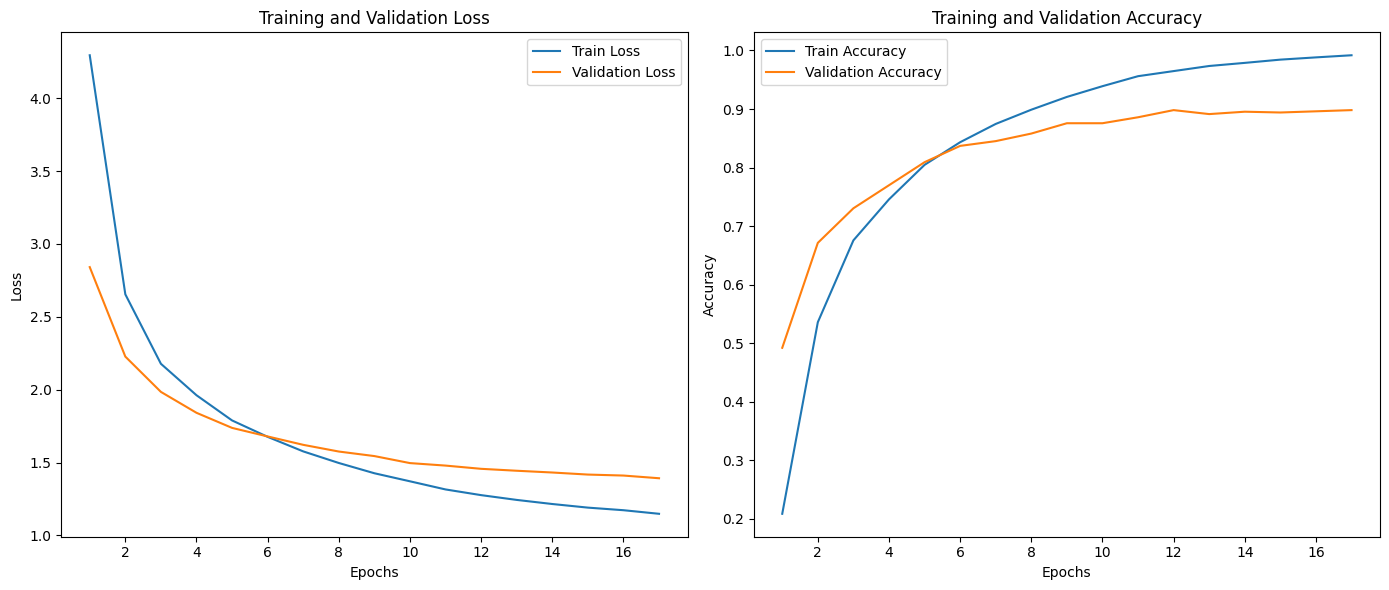

In [22]:
model_ft, history = train_model(model, criterion, optimizer, scheduler, num_epochs=20)
plot_training_history(history)

# Save final model

In [24]:
torch.save(model_ft.state_dict(), 'final_model.pt')
print("Final model saved as 'final_model.pt'")

Final model saved as 'final_model.pt'


# evaluate the model on test data

In [25]:
def evaluate_model(model, test_loader):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / test_data_len
    print(f'Test Accuracy: {test_acc:.4f}')
    return test_acc.item()

test_accuracy = evaluate_model(model_ft, test_loader)

Evaluating: 100%|██████████| 24/24 [00:42<00:00,  1.75s/it]

Test Accuracy: 0.8921


# Display final accuracy results

In [26]:
print(f"Best Validation Accuracy: {max(history['val_acc']):.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Best Validation Accuracy: 0.8982
Final Test Accuracy: 0.8921
